In [5]:
import yfinance as yf
import pandas as pd

# Download 15-minute data for HDFC Bank
ticker = 'HDFCBANK.NS'
data = yf.download(ticker, interval='15m', period='40d')  # Adjust period as needed

# Display the first few rows
print(data.head())


[*********************100%%**********************]  1 of 1 completed
                            Open         High          Low        Close  \
Datetime                                                                  
2024-05-10 09:15:00  1437.650024  1440.849976  1433.000000  1439.500000   
2024-05-10 09:30:00  1439.550049  1447.000000  1438.400024  1446.199951   
2024-05-10 09:45:00  1446.349976  1447.550049  1443.199951  1445.750000   
2024-05-10 10:00:00  1445.750000  1451.750000  1445.750000  1450.550049   
2024-05-10 10:15:00  1450.349976  1451.949951  1447.199951  1449.000000   

                       Adj Close   Volume  
Datetime                                   
2024-05-10 09:15:00  1439.500000   871910  
2024-05-10 09:30:00  1446.199951  1019075  
2024-05-10 09:45:00  1445.750000   604266  
2024-05-10 10:00:00  1450.550049   551742  
2024-05-10 10:15:00  1449.000000   398619  


In [6]:
data

,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2024-05-10 09:15:00,1437.650024,1440.849976,1433.000000,1439.500000,1439.500000,871910
2024-05-10 09:30:00,1439.550049,1447.000000,1438.400024,1446.199951,1446.199951,1019075
2024-05-10 09:45:00,1446.349976,1447.550049,1443.199951,1445.750000,1445.750000,604266
2024-05-10 10:00:00,1445.750000,1451.750000,1445.750000,1450.550049,1450.550049,551742
2024-05-10 10:15:00,1450.349976,1451.949951,1447.199951,1449.000000,1449.000000,398619
...,...,...,...,...,...,...
2024-07-05 14:30:00,1644.400024,1646.500000,1643.000000,1644.849976,1644.849976,1120087
2024-07-05 14:45:00,1644.849976,1645.250000,1642.199951,1643.500000,1643.500000,1222347
2024-07-05 15:00:00,1643.449951,1651.099976,1643.199951,1647.949951,1647.949951,2819403


In [7]:
def calculate_pivot_points(df):
    df['PP'] = (df['High'] + df['Low'] + df['Close']) / 3
    df['R1'] = 2 * df['PP'] - df['Low']
    df['S1'] = 2 * df['PP'] - df['High']
    df['R2'] = df['PP'] + (df['High'] - df['Low'])
    df['S2'] = df['PP'] - (df['High'] - df['Low'])
    df['R3'] = df['High'] + 2 * (df['PP'] - df['Low'])
    df['S3'] = df['Low'] - 2 * (df['High'] - df['PP'])
    
    df['TC'] = (df['High'] + df['Low']) / 2
    df['BC'] = (df['High'] + df['Close'] + df['Low']) / 3
    df['CPR'] = (df['TC'] + df['BC']) / 2
    
    return df

data = data.groupby(data.index.date).apply(calculate_pivot_points)
print(data[['PP', 'R1', 'S1', 'R2', 'S2', 'R3', 'S3', 'TC', 'BC', 'CPR']].head())


                                         PP           R1           S1  \
           Datetime                                                     
2024-05-10 2024-05-10 09:15:00  1437.783325  1442.566650  1434.716675   
           2024-05-10 09:30:00  1443.866659  1449.333293  1440.733317   
           2024-05-10 09:45:00  1445.500000  1447.800049  1443.449951   
           2024-05-10 10:00:00  1449.350016  1452.950033  1446.950033   
           2024-05-10 10:15:00  1449.383301  1451.566650  1446.816650   

                                         R2           S2           R3  \
           Datetime                                                     
2024-05-10 2024-05-10 09:15:00  1445.633301  1429.933350  1450.416626   
           2024-05-10 09:30:00  1452.466634  1435.266683  1457.933268   
           2024-05-10 09:45:00  1449.850098  1441.149902  1452.150146   
           2024-05-10 10:00:00  1455.350016  1443.350016  1458.950033   
           2024-05-10 10:15:00  1454.133301  1444.

[*********************100%%**********************]  1 of 1 completed
Starting Portfolio Value: 100000.00
Final Portfolio Value: 112681.48


<IPython.core.display.Javascript object>


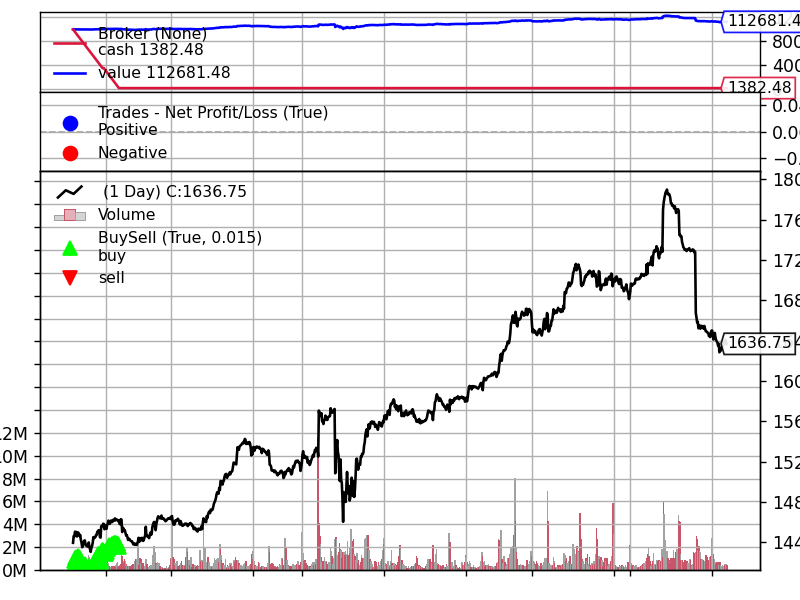

In [36]:
import backtrader as bt
import yfinance as yf
import pandas as pd

class PivotPointStrategy(bt.Strategy):
    params = (
        ('take_profit_factor', 10.02),
        ('stop_loss_factor', 0.95),
    )

    def __init__(self):
        self.order = None
        self.buyprice = None
        self.buycomm = None

    def next(self):
        if self.order:
            return

        entry_price = self.data.close[0]
        buy_conditions = [
            entry_price > 1.02 * self.data.lines[i][0] for i in range(1, 10)
        ]
        sell_conditions = [
            entry_price < 0.98 * self.data.lines[i][0] for i in range(1, 10)
        ]

        if any(buy_conditions):
            next_resistance = max([self.data.lines[i][0] for i in range(4, 7) if self.data.lines[i][0] > entry_price])
            self.order = self.buy(exectype=bt.Order.Limit, price=entry_price, transmit=False)
            self.take_profit_order = self.sell(exectype=bt.Order.Limit, price=next_resistance, transmit=False, parent=self.order)
            self.stop_loss_order = self.sell(exectype=bt.Order.Stop, price=entry_price * self.params.stop_loss_factor, transmit=True, parent=self.order)

        elif any(sell_conditions):
            next_support = min([self.data.lines[i][0] for i in range(7, 10) if self.data.lines[i][0] < entry_price])
            self.order = self.sell(exectype=bt.Order.Limit, price=entry_price, transmit=False)
            self.take_profit_order = self.buy(exectype=bt.Order.Limit, price=next_support, transmit=False, parent=self.order)
            self.stop_loss_order = self.buy(exectype=bt.Order.Stop, price=entry_price / self.params.stop_loss_factor, transmit=True, parent=self.order)

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return

        if order.status in [order.Completed]:
            if order.isbuy():
                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            self.bar_executed = len(self)

        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        print(f'Operation Profit, Gross {trade.pnl}, Net {trade.pnlcomm}')

class YahooFinanceData(bt.feeds.PandasData):
    lines = ('PP', 'CPR', 'R1', 'R2', 'R3', 'TC', 'BC', 'S1', 'S2', 'S3')
    params = (
        ('datetime', None),
        ('open', -1),
        ('high', -1),
        ('low', -1),
        ('close', -1),
        ('volume', -1),
        ('PP', -1),
        ('CPR', -1),
        ('R1', -1),
        ('R2', -1),
        ('R3', -1),
        ('TC', -1),
        ('BC', -1),
        ('S1', -1),
        ('S2', -1),
        ('S3', -1),
    )

if __name__ == '__main__':
    cerebro = bt.Cerebro()

    # Add the strategy
    cerebro.addstrategy(PivotPointStrategy)

    # Download data
    ticker = 'HDFCBANK.NS'
    data = yf.download(ticker, interval='15m', period='40d')

    # Add pivot points and other levels to the data
    data['PP'] = (data['High'] + data['Low'] + data['Close']) / 3
    data['R1'] = 2 * data['PP'] - data['Low']
    data['S1'] = 2 * data['PP'] - data['High']
    data['R2'] = data['PP'] + (data['High'] - data['Low'])
    data['S2'] = data['PP'] - (data['High'] - data['Low'])
    data['R3'] = data['High'] + 2 * (data['PP'] - data['Low'])
    data['S3'] = data['Low'] - 2 * (data['High'] - data['PP'])
    data['CPR'] = data['High'] - data['Low']
    data['TC'] = data['PP'] + (data['High'] - data['Low'])
    data['BC'] = data['PP'] - (data['High'] - data['Low'])

    # Add the data feed
    data_feed = YahooFinanceData(dataname=data)
    cerebro.adddata(data_feed)

    # Set initial cash
    cerebro.broker.setcash(100000.0)

    # Set commission
    cerebro.broker.setcommission(commission=0.001)

    # Run the strategy
    print(f'Starting Portfolio Value: {cerebro.broker.getvalue():.2f}')
    cerebro.run()
    print(f'Final Portfolio Value: {cerebro.broker.getvalue():.2f}')

    # Plot the result
    cerebro.plot()